## 1 Data Collection and Preparation


In [2]:
import pandas as pd
from fredapi import Fred

# Initialize Fred API
fred = Fred(api_key='121aa3d574f47586d48ca94b632f6805')

# Fetch data
gdp_growth = fred.get_series('A191RL1Q225SBEA')
inflation_rate = fred.get_series('CPIAUCSL')
unemployment_rate = fred.get_series('UNRATE')

# Prepare DataFrame
data = pd.DataFrame({
    'GDP_Growth': gdp_growth,
    'Inflation_Rate': inflation_rate.pct_change()*100,
    'Unemployment_Rate': unemployment_rate
})

# Resample to quarterly and handle missing values
data = data.resample('QE').mean().dropna()

## 2 Exploratory Data Analysis


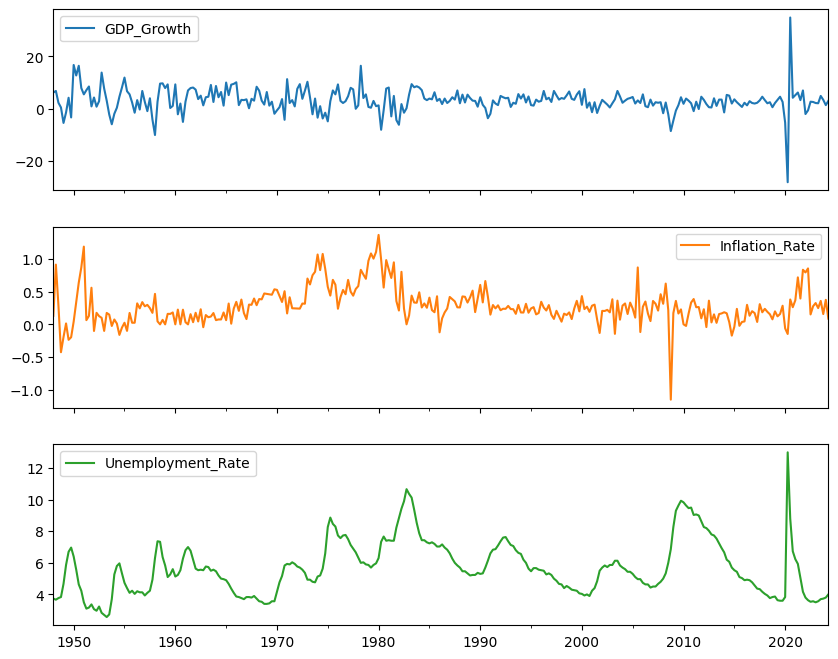

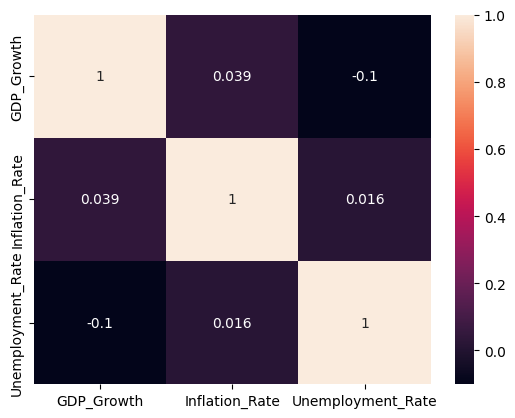

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Time series plots
data.plot(subplots=True, figsize=(10, 8))
plt.show()

# Correlation matrix
sns.heatmap(data.corr(), annot=True)
plt.show()

## 3 Testing for Stationarity

VAR models require stationary time series. We perform Augmented Dickey-Fuller (ADF) tests to check stationarity.


### 3.1 ADF Test


In [4]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series, title=''):
    result = adfuller(series.dropna())
    print(f'ADF Statistic for {title}: {result[0]}')
    print(f'p-value: {result[1]}')

# Perform ADF tests
adf_test(data['GDP_Growth'], 'GDP Growth')
adf_test(data['Inflation_Rate'], 'Inflation Rate')
adf_test(data['Unemployment_Rate'], 'Unemployment Rate')

#If the series are non-stationary, differencing transforms them into stationary series suitable for VAR.
'''
data_diff = data.diff().dropna()

# Re-test for stationarity
adf_test(data_diff['GDP_Growth'], 'GDP Growth Differenced')
adf_test(data_diff['Inflation_Rate'], 'Inflation Rate Differenced')
adf_test(data_diff['Unemployment_Rate'], 'Unemployment Rate Differenced')
'''

ADF Statistic for GDP Growth: -15.249125675746596
p-value: 5.037916062616795e-28
ADF Statistic for Inflation Rate: -4.458885090752787
p-value: 0.00023315840753908177
ADF Statistic for Unemployment Rate: -3.6906920859975383
p-value: 0.004245999578298361


"\ndata_diff = data.diff().dropna()\n\n# Re-test for stationarity\nadf_test(data_diff['GDP_Growth'], 'GDP Growth Differenced')\nadf_test(data_diff['Inflation_Rate'], 'Inflation Rate Differenced')\nadf_test(data_diff['Unemployment_Rate'], 'Unemployment Rate Differenced')\n"

In the ADF test, the null hypothesis (H_0) is that the time series has a unit root (i.e., it is non-stationary). The alternative hypothesis (H_1) is that the series is stationary.

Since the p-values for all three series are less than the typical significance level of 0.05, you can reject the null hypothesis for each series:

- GDP Growth: The p-value is effectively zero, indicating strong evidence against the null hypothesis.
- Inflation Rate: The p-value is 0.000233, well below 0.05.
- Unemployment Rate: The p-value is 0.004246, also below 0.05.

Conclusion:

All three time series are stationary, meaning they do not require differencing or other transformations to achieve stationarity.


### 3.2 KPSS Test


In [5]:
from statsmodels.tsa.stattools import kpss

def kpss_test(series, **kw):
    statistic, p_value, n_lags, critical_values = kpss(series.dropna(), **kw)
    print(f'KPSS Statistic: {statistic}, p-value: {p_value}')

kpss_test(data['GDP_Growth'])
kpss_test(data['Inflation_Rate'])
kpss_test(data['Unemployment_Rate'])

KPSS Statistic: 0.5123740811181763, p-value: 0.03887971145987021
KPSS Statistic: 0.3200301079900464, p-value: 0.1
KPSS Statistic: 0.2951656427209626, p-value: 0.1


/tmp/ipykernel_7150/834434606.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  statistic, p_value, n_lags, critical_values = kpss(series.dropna(), **kw)
/tmp/ipykernel_7150/834434606.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  statistic, p_value, n_lags, critical_values = kpss(series.dropna(), **kw)


GDP Growth:

- p-value = 0.03888 is less than 0.05.
- We reject the null hypothesis of stationarity.
- Conclusion: The series is non-stationary.

Inflation Rate and Unemployment Rate:

- p-values >= 0.1 (and possibly higher due to the warning).
- We fail to reject the null hypothesis of stationarity.
- Conclusion: The series are stationary.


### 3.3 Phillips Perron Test


In [6]:
from arch.unitroot import PhillipsPerron

def pp_test(series):
    pp = PhillipsPerron(series)
    print(pp.summary().as_text())

pp_test(data['GDP_Growth'])
pp_test(data['Inflation_Rate'])
pp_test(data['Unemployment_Rate'])

     Phillips-Perron Test (Z-tau)    
Test Statistic                -15.191
P-value                         0.000
Lags                               16
-------------------------------------

Trend: Constant
Critical Values: -3.45 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
     Phillips-Perron Test (Z-tau)    
Test Statistic                -11.211
P-value                         0.000
Lags                               16
-------------------------------------

Trend: Constant
Critical Values: -3.45 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
     Phillips-Perron Test (Z-tau)    
Test Statistic                 -3.701
P-value                         0.004
Lags                               16
-------------------------------------

Trend: Constant
Critical Values: -3.45 (1%), -2.87 (5%), -2.57 (10%)
Nu

The PP test modifies the test statistics to account for serial correlation and heteroskedasticity in the error terms without adding lagged difference terms.

- Conclusion: Reject the null hypothesis of a unit root.
- Result: All three series are stationary.


### 3.4 Zivot Andrews Test


In [7]:
from statsmodels.tsa.stattools import zivot_andrews

def za_test(series, **kw):
    statistic, p_value, cvdict, baselag, bpidx = zivot_andrews(series.dropna(), **kw)
    print(f'ZA Statistic: {statistic}, p-value: {p_value}, critical values: {cvdict}, best lag: {baselag}, break point index: {bpidx}')

za_test(data['GDP_Growth'])
za_test(data['Inflation_Rate'])
za_test(data['Unemployment_Rate'])

ZA Statistic: -15.595534150826195, p-value: 1e-05, critical values: {'1%': -5.27644, '5%': -4.81067, '10%': -4.56618}, best lag: 0, break point index: 139
ZA Statistic: -5.614184120864695, p-value: 0.002694419085919662, critical values: {'1%': -5.27644, '5%': -4.81067, '10%': -4.56618}, best lag: 2, break point index: 76
ZA Statistic: -4.324435905274828, p-value: 0.18148916381438732, critical values: {'1%': -5.27644, '5%': -4.81067, '10%': -4.56618}, best lag: 0, break point index: 87


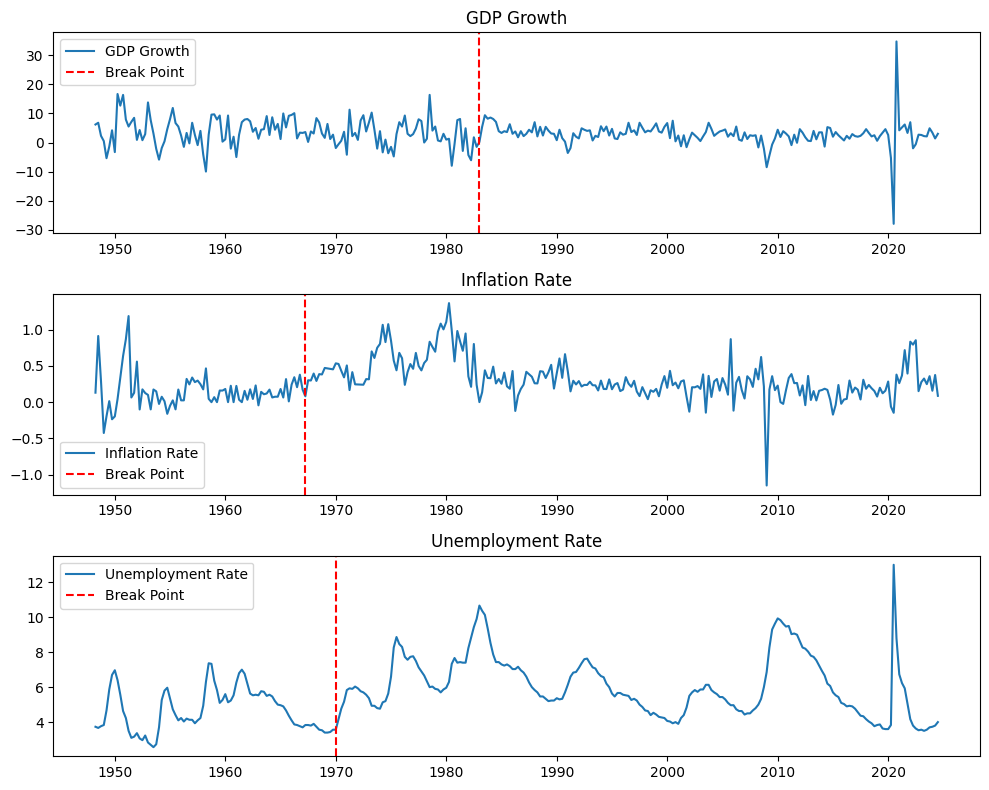

In [8]:
# Plot with 3 subplots
fig, axes = plt.subplots(3, 1, figsize=(10, 8))

# First subplot: GDP Growth with break point
axes[0].plot(data.index, data['GDP_Growth'], label='GDP Growth')
axes[0].axvline(data.index[139], color='r', linestyle='--', label='Break Point')
axes[0].set_title('GDP Growth')
axes[0].legend()

# Second subplot: Inflation Rate with break point
axes[1].plot(data.index, data['Inflation_Rate'], label='Inflation Rate')
axes[1].axvline(data.index[76], color='r', linestyle='--', label='Break Point')
axes[1].set_title('Inflation Rate')
axes[1].legend()

# Third subplot: Unemployment Rate
axes[2].plot(data.index, data['Unemployment_Rate'], label='Unemployment Rate')
axes[2].axvline(data.index[87], color='r', linestyle='--', label='Break Point')
axes[2].set_title('Unemployment Rate')
axes[2].legend()

plt.tight_layout()
plt.show()

1. GDP Growth

- Conclusion: We reject the null hypothesis at the 1% significance level.
- Implication: The GDP Growth series is stationary with a structural break at index 139.

2. Inflation Rate

- Conclusion: We reject the null hypothesis at the 1% significance level.
- Implication: The Inflation Rate series is stationary with a structural break at index 76.

3. Unemployment Rate

- Conclusion: We fail to reject the null hypothesis.
- Implication: The Unemployment Rate series is non-stationary, even when allowing for a structural break.


### 3.5 Johansen Cointegration Test


In [9]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

johansen_test = coint_johansen(data[['GDP_Growth', 'Inflation_Rate', 'Unemployment_Rate']], det_order=0, k_ar_diff=1)
print(johansen_test.lr1)  # Trace statistic

[196.52183257  56.35586853  13.02743853]


The Johansen Cointegration Test suggests that all possible cointegrating relationships are significant.

Implications

- Cointegration: The variables are cointegrated, indicating long-term equilibrium relationships among them.
- Action: Use a Vector Error Correction Model (VECM) instead of a standard VAR model to capture both short-term dynamics and long-term relationships.


#### Interpreting the Overall Evidence

- Majority of Tests (ADF, PP, Zivot-Andrews) suggest the series are stationary.
- KPSS Test suggests that GDP Growth is non-stationary.
- Economic Theory:
  - GDP growth rates are often considered stationary in macroeconomic theory.
  - Inflation rates and unemployment rates are also typically treated as stationary variables.


## 4 Estimating the Model


In [10]:
from statsmodels.tsa.api import VAR

# Initialize the VAR model
model = VAR(data)

# Select the optimal lag order
lag_order_results = model.select_order(maxlags=12)
print(lag_order_results.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        1.435       1.473       4.199       1.450
1       -1.638      -1.487      0.1944      -1.578
2       -1.852     -1.589*      0.1570      -1.746
3      -1.910*      -1.534     0.1481*     -1.759*
4       -1.877      -1.389      0.1530      -1.682
5       -1.857      -1.255      0.1563      -1.616
6       -1.810      -1.096      0.1638      -1.524
7       -1.787     -0.9602      0.1676      -1.456
8       -1.812     -0.8728      0.1635      -1.436
9       -1.776     -0.7231      0.1697      -1.354
10      -1.761     -0.5962      0.1722      -1.295
11      -1.742     -0.4644      0.1757      -1.231
12      -1.696     -0.3052      0.1842      -1.139
--------------------------------------------------


- AIC and FPE: Both criteria suggest that the optimal lag length is 3, as indicated by the minimum values at lag 3.
- BIC: Suggests an optimal lag length of 2.
- HQIC: Also suggests that the optimal lag length is 3.

Given that AIC, FPE, and HQIC all suggest a lag length of 3, and considering that these criteria are generally more suitable for model selection in VAR due to their tendency to favor models with better in-sample fit, it’s reasonable to proceed with a lag length of 3.


In [11]:
# Fit the VAR model
optimal_lag = 3
var_model = model.fit(optimal_lag)
print(var_model.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 21, Sep, 2024
Time:                     15:31:53
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -1.39975
Nobs:                     303.000    HQIC:                  -1.62034
Log likelihood:          -992.047    FPE:                   0.170781
AIC:                     -1.76744    Det(Omega_mle):        0.154930
--------------------------------------------------------------------
Results for equation GDP_Growth
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
const                       -1.741242         1.021104           -1.705           0.088
L1.GDP_Growth                0.441174         0.079194            5.571           0.000
L1.Inflation_Rate          

GDP_Growth Equation:

Significant Variables (p < 0.05):

- L1.GDP_Growth: Positive and significant; current GDP growth is positively influenced by its first lag.
- L1.Unemployment_Rate: Positive and significant; current GDP growth is positively influenced by the first lag of unemployment rate.
- L2.GDP_Growth: Positive and significant; second lag of GDP growth has a positive effect.
- L2.Unemployment_Rate: Negative and significant; second lag of unemployment rate negatively affects GDP growth.

Variables with Marginal Significance:

- L2.Inflation_Rate: Negative coefficient with p-value of 0.075; suggests a possible negative effect on GDP growth.


Inflation_Rate Equation:

Significant Variables (p < 0.05):

- L1.Inflation_Rate: Positive and significant; inflation rate is strongly influenced by its first lag.
- L2.Inflation_Rate: Positive and significant; second lag also affects current inflation.
- L3.Inflation_Rate: Positive and significant; third lag has a significant effect.

Variables with Marginal Significance:

- L1.GDP_Growth: p-value of 0.095; suggests a possible positive effect on inflation.
- L3.GDP_Growth: p-value of 0.090; may indicate a delayed effect of GDP growth on inflation.


Unemployment_Rate Equation:

Significant Variables (p < 0.05):

- L1.GDP_Growth: Negative and significant; higher past GDP growth reduces current unemployment.
- L1.Unemployment_Rate: Positive and significant; unemployment rate is influenced by its own past values.
- L2.GDP_Growth: Negative and significant; the second lag of GDP growth also reduces unemployment.
- L2.Unemployment_Rate: Positive and significant; second lag has a positive effect.

Variables with Non-significant Coefficients:

- Inflation_Rate lags: Not significant, suggesting limited direct impact on unemployment in the short term.


Correlation Matrix of Residuals

- GDP_Growth and Unemployment_Rate: Strong negative correlation (-0.6736) in residuals, indicating that even after modeling, there is an inverse relationship.
- GDP_Growth and Inflation_Rate: Weak positive correlation (0.1433).
- Inflation_Rate and Unemployment_Rate: Weak negative correlation (-0.1307).


Key Findings

GDP_Growth Equation:

- Persistence: GDP growth is influenced by its own past values (lags 1 and 2), indicating persistence over time.
- Unemployment Rate Impact:
  - Positive Effect (L1): The first lag of unemployment rate positively affects GDP growth, which may seem counterintuitive.
  - Negative Effect (L2): The second lag has a negative effect, aligning with economic expectations.
- Inflation Rate Impact: Generally not significant, suggesting limited immediate impact on GDP growth.

Inflation_Rate Equation:

- Strong Autocorrelation: Inflation rate is heavily influenced by its own lags (1, 2, and 3).
- GDP_Growth Impact: Some evidence of GDP growth affecting inflation, but significance is marginal.

Unemployment_Rate Equation:

- Negative Relationship with GDP Growth: Consistent with economic theory (Okun’s Law), higher GDP growth reduces unemployment.
- Persistence in Unemployment: Unemployment rate is influenced by its own past values (lags 1 and 2).

Model Adequacy

- Significance of Coefficients: Many coefficients are statistically significant, indicating that the model captures important relationships.
- Residual Correlation: The residuals’ correlation suggests that the model may not fully account for all dynamics, especially between GDP growth and unemployment rate.


## 5 Diagnostics and Validation


### 5.1 Ljung-Box Test


In [12]:
# Residual analysis
from statsmodels.stats.diagnostic import acorr_ljungbox

# Apply Ljung-Box test to each column of residuals
lb_test_results = {}
for column in var_model.resid.columns:
    lb_test_results[column] = acorr_ljungbox(var_model.resid[column], lags=[12], return_df=True)

# Convert results to a DataFrame for better readability
lb_test_df = pd.concat(lb_test_results, axis=1)
print(lb_test_df)

# Stability test
print('VAR Model Stability:', var_model.is_stable())

   GDP_Growth           Inflation_Rate           Unemployment_Rate          
      lb_stat lb_pvalue        lb_stat lb_pvalue           lb_stat lb_pvalue
12   5.227397  0.949949      13.056324   0.36496          3.028353  0.995341
VAR Model Stability: True


Ljung-Box Test:

1. GDP_Growth:

- Interpretation:
  - The high p-value (approximately 0.95) indicates that we fail to reject the null hypothesis of no autocorrelation.
  - Conclusion: The residuals for GDP_Growth are not autocorrelated up to lag 12.

2. Inflation_Rate:

- Interpretation:
  - The p-value is greater than the standard significance level of 0.05.
  - Conclusion: We fail to reject the null hypothesis. Residuals for Inflation_Rate show no significant autocorrelation.

3. Unemployment_Rate:

- Interpretation:
  - The p-value is extremely high (close to 1), indicating strong evidence of no autocorrelation.
  - Conclusion: Residuals for Unemployment_Rate are not autocorrelated.

Stability Test:

Overall Conclusion:

- For all variables, the p-values are significantly greater than 0.05.
- Implication: The residuals behave like white noise, satisfying one of the key assumptions of the VAR model.

Result: The output True signifies that all eigenvalues are within the unit circle.
Implication:

- The VAR(3) model is stable.
- Forecasts from the model will not diverge over time.
- Impulse response functions will produce meaningful and reliable results.


### 5.2 Impulse Response Functions


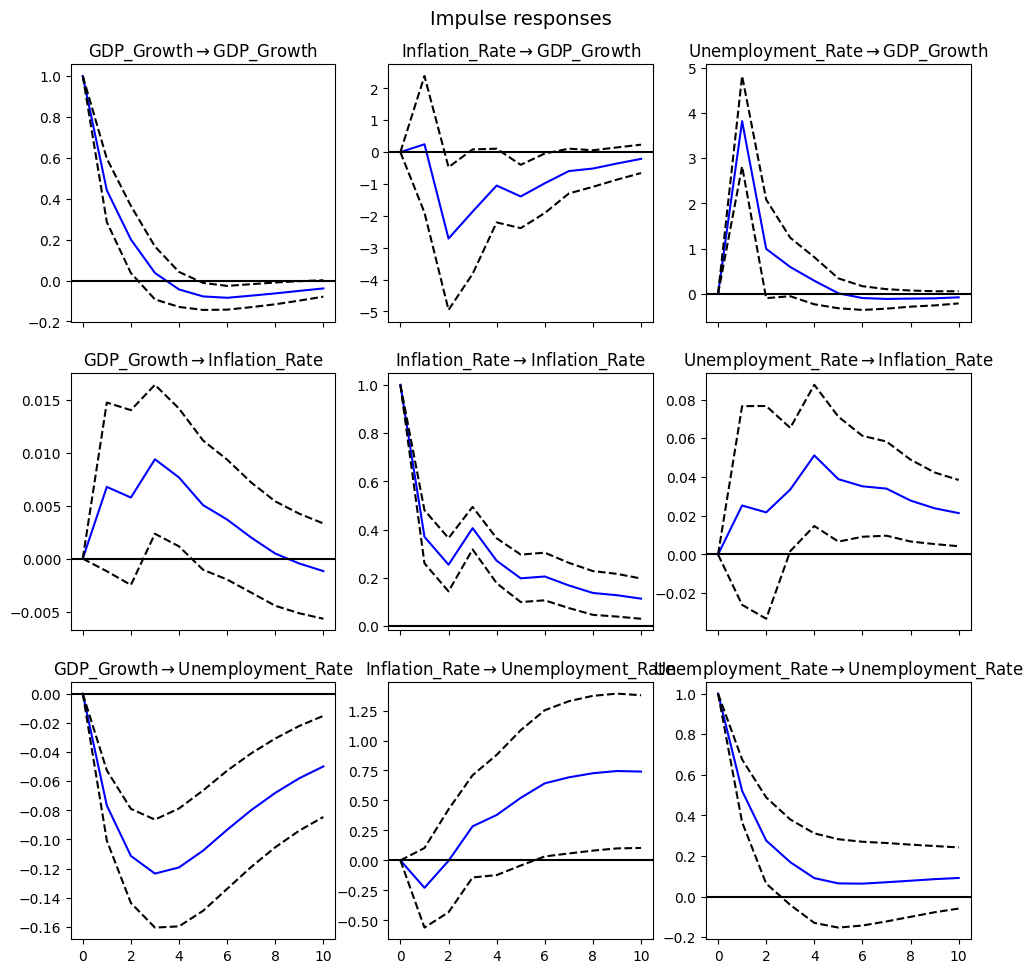

In [13]:
# Generate impulse response functions
irf = var_model.irf(10)
irf.plot(orth=False)
plt.show()

### Interpretation of Impulse Response Functions (IRFs)

The Impulse Response Functions (IRFs) from the VAR model illustrate how each variable responds to a one-standard-deviation shock in another variable over time. These responses allow us to see the dynamic relationships between **GDP Growth**, **Inflation Rate**, and **Unemployment Rate** in your model.

#### General Structure of the IRFs

- The **solid blue line** represents the response of the variable to a shock.
- The **dashed lines** represent the **95% confidence intervals** around the response. If the confidence interval includes zero, the response is not statistically significant at the 5% level.

### Top Row (Response of GDP Growth)

#### 1. **GDP Growth → GDP Growth**

- **Interpretation**:
  - A shock to GDP growth has a **positive and significant** effect on itself, indicating that GDP growth is **persistent**.
  - Over time, this effect diminishes to zero, implying that while GDP growth responds to its own shocks in the short run, the effect fades in the long run.

#### 2. **Inflation Rate → GDP Growth**

- **Interpretation**:
  - A shock to the inflation rate leads to a **negative impact** on GDP growth, particularly in the short term. After an initial drop, the response starts to recover but remains below zero.
  - This suggests that inflation shocks may have **short-term negative effects** on economic growth, but the impact fades as time passes.

#### 3. **Unemployment Rate → GDP Growth**

- **Interpretation**:
  - A shock to the unemployment rate results in a **sharp decline** in GDP growth, which is statistically significant. This relationship aligns with **Okun’s Law**, where higher unemployment is associated with lower GDP growth.
  - The negative effect decreases over time but is quite pronounced initially.

### Middle Row (Response of Inflation Rate)

#### 4. **GDP Growth → Inflation Rate**

- **Interpretation**:
  - A shock to GDP growth has a **small, positive effect** on inflation, although the effect is not very strong.
  - The influence of GDP growth on inflation is modest, suggesting that **economic growth only marginally contributes** to inflationary pressures in the short run.

#### 5. **Inflation Rate → Inflation Rate**

- **Interpretation**:
  - Inflation rate shocks have a **strong, positive, and persistent** effect on future inflation. This implies that inflation is **highly autocorrelated**, meaning inflation shocks tend to perpetuate themselves over time.
  - This persistence reflects inflation inertia, where inflation remains high for some time after a shock.

#### 6. **Unemployment Rate → Inflation Rate**

- **Interpretation**:
  - A shock to the unemployment rate appears to have **little to no significant effect** on the inflation rate, as the confidence interval includes zero for most periods.
  - This suggests that unemployment shocks may not directly influence inflation in the short term within this model.

### Bottom Row (Response of Unemployment Rate)

#### 7. **GDP Growth → Unemployment Rate**

- **Interpretation**:
  - A shock to GDP growth results in a **negative and significant effect** on the unemployment rate, meaning higher GDP growth tends to reduce unemployment, consistent with **Okun’s Law**.
  - This effect diminishes over time, indicating that GDP growth impacts unemployment strongly in the short term.

#### 8. **Inflation Rate → Unemployment Rate**

- **Interpretation**:
  - A shock to inflation initially has little effect on unemployment, but the response becomes positive over time, though the impact is relatively small.
  - This could suggest some **longer-term impact** of inflation on unemployment, though the effect is not robustly significant in the short term.

#### 9. **Unemployment Rate → Unemployment Rate**

- **Interpretation**:
  - A shock to the unemployment rate has a **positive and significant impact** on itself, but the effect decays over time.
  - This suggests that unemployment rate shocks are persistent, but their influence diminishes over several periods.

### Key Takeaways

- **GDP Growth**:
  - GDP growth is persistent (responds to its own shocks).
  - It is negatively affected by unemployment rate shocks, consistent with economic theory.
  - Inflation rate shocks have a negative short-term effect on GDP growth.
- **Inflation Rate**:
  - Inflation is highly persistent, responding strongly to its own shocks.
  - GDP growth marginally affects inflation, while unemployment has little to no effect on inflation.
- **Unemployment Rate**:
  - GDP growth strongly reduces unemployment, consistent with **Okun’s Law**.
  - Inflation has a small, delayed positive effect on unemployment, though the effect is not very strong.

### Next Steps

#### 1. **Interpret Economic Insights**

- Use the IRFs to draw policy conclusions. For instance, if your goal is to reduce unemployment, focusing on GDP growth-enhancing policies might be effective, as higher GDP growth reduces unemployment.
- Inflation shocks may have negative short-term effects on GDP growth, so inflation control policies could be important for stabilizing growth.

#### 2. **Conduct Forecasting**

- These IRFs can help predict how the economy might respond to future shocks (e.g., a sudden rise in inflation or unemployment).

#### 3. **Check Robustness**

- Consider testing for different lag lengths or re-estimating the model to ensure these results are robust.

#### 4. **Explore Economic Theory**

- These relationships can be compared against macroeconomic theories (e.g., Phillips Curve, Okun's Law) to ensure consistency with broader economic understanding.


### 5.3 Forecast Error Variance Decomposition


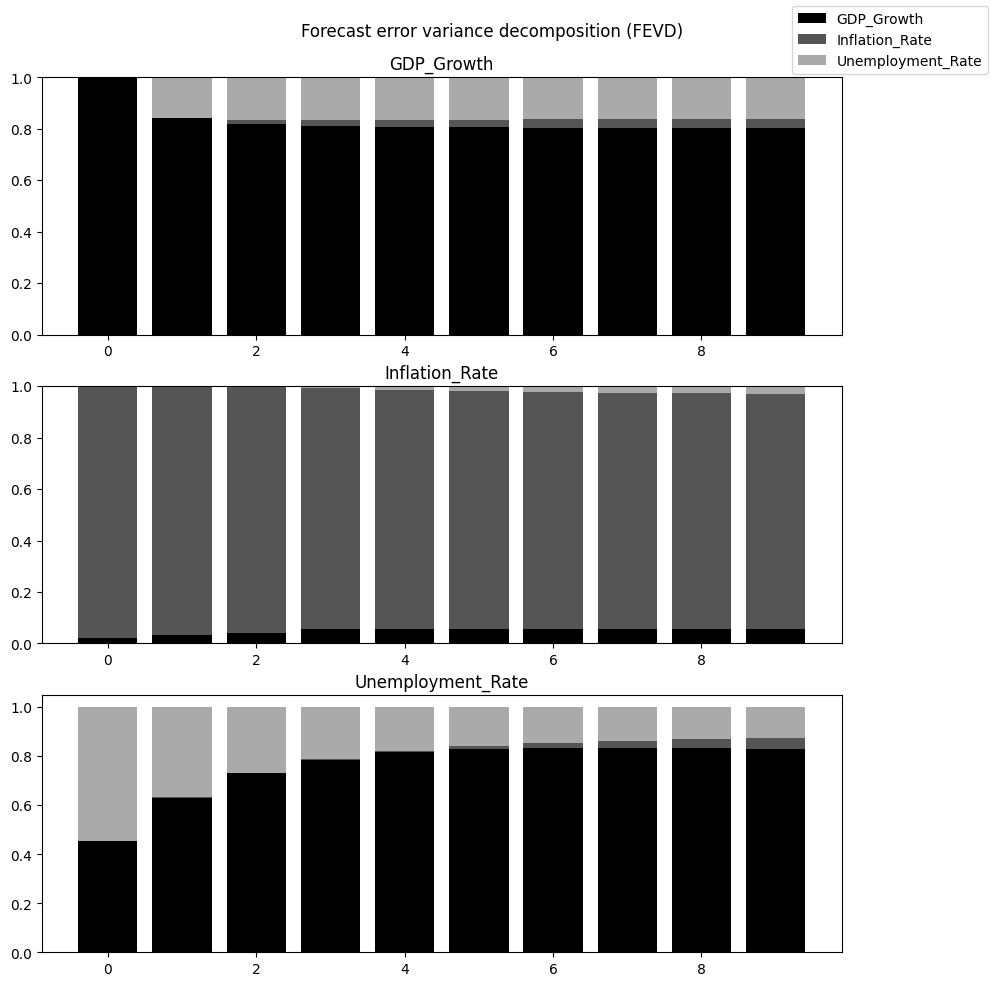

In [15]:
# Generate forecast error variance decomposition
fevd = var_model.fevd(10)
fevd.plot()
plt.show()

### Interpretation of Forecast Error Variance Decomposition (FEVD)

The **Forecast Error Variance Decomposition (FEVD)** results help us understand how much of the forecast error variance for each variable is explained by shocks to each variable in the system. In other words, FEVD indicates the relative importance of each variable in explaining the fluctuations (variance) of other variables over time.

Each bar in the plot represents the forecast error variance decomposition at different time horizons, with the colored sections indicating the proportion of variance explained by the three variables: **GDP Growth**, **Inflation Rate**, and **Unemployment Rate**.

#### General Overview

- **X-Axis**: Time horizons (0, 2, 4, 6, 8 periods ahead).
- **Y-Axis**: The proportion of forecast error variance explained (from 0 to 1, or 0% to 100%).

### 1. **GDP Growth Variance Decomposition**

#### **Key Insight**:

- The vast majority of the forecast error variance for **GDP Growth** is explained by shocks to **GDP Growth** itself. Initially, nearly 100% of the variance is due to its own shocks, and this dominance persists even at longer horizons (up to 8 periods).
- Over time, **Unemployment Rate** shocks (gray bars) explain a small but gradually increasing proportion of the forecast error variance in GDP Growth.
- **Inflation Rate** (black) has a negligible impact on explaining the variance in GDP Growth.

#### **Conclusion**:

- **GDP Growth** is primarily driven by its own shocks, indicating strong persistence. Other variables (Unemployment Rate and Inflation Rate) have limited influence on GDP Growth in the forecast horizon.

### 2. **Inflation Rate Variance Decomposition**

#### **Key Insight**:

- **Inflation Rate** variance is largely driven by its own shocks throughout the entire forecast horizon. Almost 100% of the forecast error variance in **Inflation Rate** is explained by inflation shocks.
- Shocks to **GDP Growth** (black) and **Unemployment Rate** (gray) have virtually no impact on explaining the variance in the Inflation Rate.

#### **Conclusion**:

- The **Inflation Rate** behaves autonomously, with minimal influence from GDP Growth or Unemployment Rate. Inflation dynamics are mostly explained by **inflation shocks**, reflecting strong persistence in inflation over time.

### 3. **Unemployment Rate Variance Decomposition**

#### **Key Insight**:

- Initially, the forecast error variance for **Unemployment Rate** is split between shocks to **Unemployment Rate** itself and **GDP Growth**.
- Over time, shocks to **GDP Growth** (black) become increasingly important, explaining a large and growing portion of the forecast error variance in unemployment.
- **Inflation Rate** has minimal influence on the forecast error variance of Unemployment Rate.

#### **Conclusion**:

- **Unemployment Rate** variance is significantly influenced by its own past shocks and GDP Growth shocks. The importance of GDP Growth increases over time, indicating a strong relationship between economic growth and employment levels.

### Key Takeaways

#### 1. **Dominance of Own Shocks**:

- **GDP Growth** and **Inflation Rate** are heavily influenced by their own shocks. This indicates persistence in both variables, where their past values play a significant role in their future movements.
- **Unemployment Rate**, while influenced by its own shocks, also shows significant sensitivity to GDP Growth shocks over time.

#### 2. **Limited Impact of Inflation**:

- **Inflation Rate** does not contribute significantly to the forecast error variance of either **GDP Growth** or **Unemployment Rate**. This suggests that inflation plays a limited role in driving the dynamics of the other two variables in this system.

#### 3. **GDP Growth’s Influence on Unemployment**:

- The **Unemployment Rate** shows increasing sensitivity to **GDP Growth** shocks over time, reinforcing the idea that economic growth is a major factor influencing unemployment levels.

### Economic Interpretation and Implications

#### **Policy Implications**:

- Policies aimed at influencing GDP Growth could have significant effects on both GDP Growth itself and the Unemployment Rate. However, such policies are unlikely to directly affect inflation, which appears more autonomous.
- Inflation-targeting policies might not have a strong impact on reducing unemployment or boosting growth in this model, as inflation does not play a major role in driving the other variables.

#### **Economic Theory**:

- The FEVD results support economic theories like **Okun’s Law**, which suggests a relationship between GDP growth and unemployment. The growing importance of GDP Growth in explaining unemployment variance over time fits this narrative.

### Next Steps

#### 1. **Further Analysis**:

- You could explore **longer forecast horizons** to see how the relationships evolve beyond the 8-period mark.

#### 2. **Robustness Check**:

- Consider testing different lag lengths or re-estimating the VAR model to ensure these results are robust.

#### 3. **Policy Simulations**:

- Use the insights from the FEVD analysis to simulate potential policy interventions, such as fiscal stimulus aimed at boosting GDP Growth and its subsequent effect on unemployment.


### 5.4 Model Validation


Validation tests the model’s predictive accuracy on unseen data.


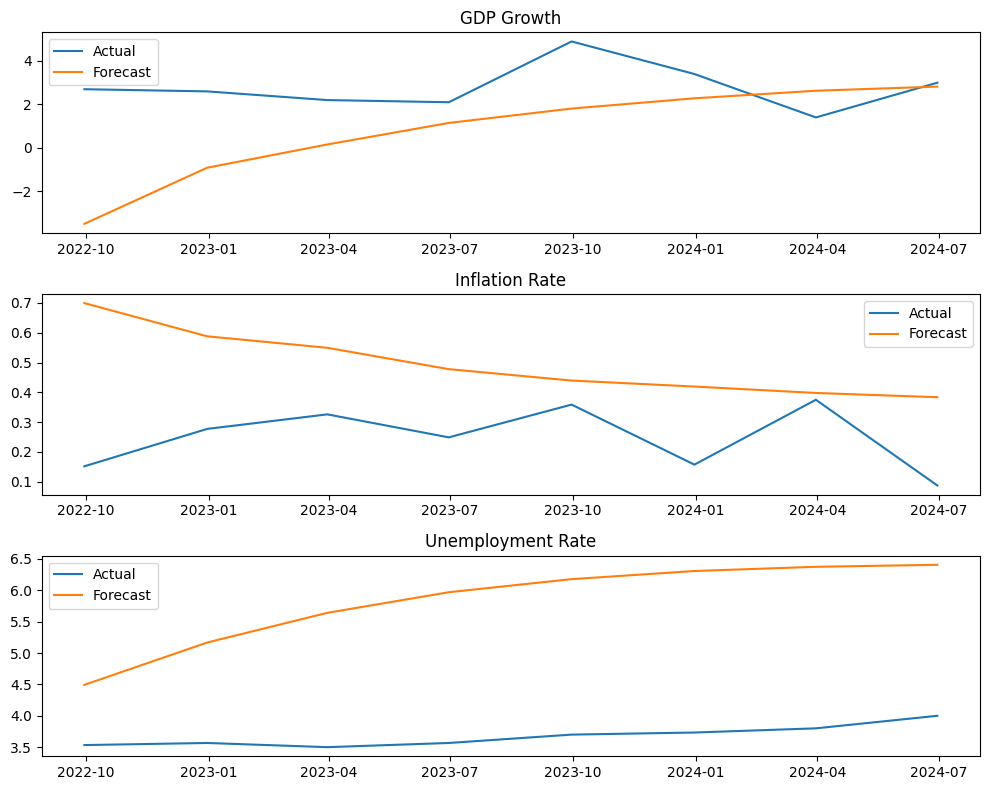

In [24]:
# Split data into training and testing sets
train = data[:-8]
test = data[-8:]

# Refit the model on training data
model = VAR(train)
results = model.fit(optimal_lag)

# Forecast
forecast = results.forecast(train.values[-results.k_ar:], steps=8)
forecast_df = pd.DataFrame(forecast, index=test.index, columns=test.columns)

# Create subplots
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 8))

# Plot GDP_Growth
axes[0].plot(test['GDP_Growth'], label='Actual')
axes[0].plot(forecast_df['GDP_Growth'], label='Forecast')
axes[0].set_title('GDP Growth')
axes[0].legend()

# Plot Inflation_Rate
axes[1].plot(test['Inflation_Rate'], label='Actual')
axes[1].plot(forecast_df['Inflation_Rate'], label='Forecast')
axes[1].set_title('Inflation Rate')
axes[1].legend()

# Plot Unemployment_Rate
axes[2].plot(test['Unemployment_Rate'], label='Actual')
axes[2].plot(forecast_df['Unemployment_Rate'], label='Forecast')
axes[2].set_title('Unemployment Rate')
axes[2].legend()

# Show plot
plt.tight_layout()
plt.show()

### 5.5 Comparison with Other Models


In [38]:
from statsmodels.tsa.vector_ar.vecm import VECM

vecm = VECM(endog=data[['GDP_Growth', 'Inflation_Rate', 'Unemployment_Rate']],
            k_ar_diff=optimal_lag,
            coint_rank=1,
            deterministic='ci')
vecm_res = vecm.fit()
print(vecm_res.summary())

# Apply Ljung-Box test to each column of residuals
lb_test_results = {}
for i in range(vecm_res.resid.shape[1]):
    lb_test_results[data.columns[i]] = acorr_ljungbox(vecm_res.resid[:,i], lags=[12], return_df=True)

# Convert results to a DataFrame for better readability
lb_test_df = pd.concat(lb_test_results, axis=1)
print(lb_test_df)


Det. terms outside the coint. relation & lagged endog. parameters for equation GDP_Growth
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
L1.GDP_Growth           -0.3965      0.134     -2.969      0.003      -0.658      -0.135
L1.Inflation_Rate        1.4966      1.135      1.319      0.187      -0.728       3.721
L1.Unemployment_Rate     3.9931      0.497      8.039      0.000       3.020       4.967
L2.GDP_Growth           -0.0715      0.110     -0.649      0.516      -0.288       0.145
L2.Inflation_Rate        0.3873      1.231      0.315      0.753      -2.025       2.799
L2.Unemployment_Rate     1.1117      0.545      2.038      0.042       0.043       2.181
L3.GDP_Growth            0.0276      0.057      0.488      0.625      -0.083       0.138
L3.Inflation_Rate        0.9814      1.119      0.877      0.380      -1.212       3.174
L3.Unemployment_Rate

Comparison of VECM and VAR:

VECM (Vector Error Correction Model)

- Cointegration: The VECM explicitly models the long-run equilibrium relationship between the variables, with significant adjustment for Inflation Rate and Unemployment Rate. GDP Growth does not seem to adjust much to long-run imbalances.
- Short-run Dynamics: The short-run coefficients in the VECM show significant effects of GDP Growth, Unemployment Rate, and Inflation Rate on their respective equations. The dynamics are complex, with some counterintuitive effects (e.g., GDP growth increasing unemployment).
- Residual Diagnostics: The residuals pass the Ljung-Box test, indicating no serial correlation.

VAR (Vector Autoregression)

- No Cointegration: The VAR model does not account for the long-run relationships between the variables. It focuses on short-run dynamics only.
- Short-run Dynamics: The VAR model also captures significant short-run effects, but it might miss out on long-run equilibrating forces that the VECM captures.
- Residual Diagnostics: The residuals in the VAR model also passed the Ljung-Box test, indicating no autocorrelation.

Key Differences

- Long-run Relationships: The VECM is superior to the VAR model in this case because the data show evidence of cointegration, meaning the variables share long-term equilibrium relationships that the VECM accounts for.
- Short-run Dynamics: Both models capture short-run dynamics, but the VECM does so while simultaneously adjusting for deviations from the long-run equilibrium.
- Recommendation: Since the test indicates cointegration, the VECM is the preferred model as it better reflects the underlying relationships in the data.

Key Takeaways

VECM Insights:

- GDP Growth: Adjusts weakly to long-run equilibrium but has significant short-term responses to unemployment.
- Inflation Rate: Adjusts significantly to long-term imbalances and shows strong persistence in the short run.
- Unemployment Rate: Strongly adjusts to restore long-term equilibrium and is influenced by GDP growth in the short run.
  Model Selection: The VECM, which includes both short-run dynamics and long-run relationships, is a more appropriate model given the presence of cointegration.


In [44]:
vecm_forecast = vecm_res.predict(steps=8)

# Calculate MSE
var_mse = mean_squared_error(test['GDP_Growth'], forecast_df['GDP_Growth'])
vecm_mse = mean_squared_error(test['GDP_Growth'], vecm_forecast[:,0])

print(f'VAR MSE: {var_mse}')
print(f'VECM MSE: {vecm_mse}')

VAR MSE: 8.531323333763464
VECM MSE: 1.7293640809514756
